In [1]:
import sys
from functions import *

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
import colormaps as cmaps

In [ ]:
predictions_df = pd.DataFrame(columns=['date'] + list(states_subdiv_mapping.keys()))



for state, subdiv in list(states_subdiv_mapping.items()):
	df, df_energy = load_data(state)
	df_full = process_data(df, df_energy, subdiv, trim = False, detrend=False)
	df_full = df_full[df_full['anomaly_against_30d_utci_mean'].notna()]
	predictions_df['date'] = df_full['date'].values
	
	df = process_data(df, df_energy, subdiv)

	df = df[feature_names_full + ['date', 'energy_met_MU']]
	df = df.dropna()
		
	X = df[feature_names_full]
	y = df['energy_met_MU']
	
	best_params = hyperparameters_dict[state]
	
	xg_reg, X_test, y_test, preds = train_model(X, y, df, best_params)#, year=2019)
	r_value, n_trees = evaluate_model(xg_reg, X_test, y_test, preds, state)
	
	X_full = df_full[feature_names_full]
	full_preds = xg_reg.predict(X_full)
	
	predictions_df[state] = full_preds
	
	#print(predictions_df)

predictions_df['Total'] = predictions_df.iloc[:, 1:].sum(axis=1)
print(predictions_df)
predictions_df.to_csv("outputs/state_energy_demand_detrended_1979_2023.csv", index=False)

In [3]:
predictions_df = pd.read_csv("outputs/state_energy_demand_detrended_1979_2023.csv")
print(predictions_df)

             date  Andhra_Pradesh  Arunachal_Pradesh      Assam      Bihar  \
0      1979-01-30       -9.458179           0.202503  -7.838278 -63.017820   
1      1979-01-31      -13.025996           0.215612  -8.240334 -43.428860   
2      1979-02-01       -9.471432           0.196113  -9.830564 -36.609790   
3      1979-02-02       -5.349980           0.318146 -11.874367 -56.548424   
4      1979-02-03       -2.437275           0.192423  -9.647451 -50.255096   
...           ...             ...                ...        ...        ...   
16485  2024-01-24        0.956572           0.104075  -8.190780 -10.570112   
16486  2024-01-25        2.230176           0.104560  -8.115454 -18.735394   
16487  2024-01-26        5.325476           0.091605  -8.416345  -8.356427   
16488  2024-01-27       -2.202635           0.080578  -7.986721 -12.891936   
16489  2024-01-28       -0.010110           0.072918  -9.938452  -1.481318   

       Chhattisgarh  Chandigarh  NCT_of_Delhi       Goa    Guja

In [4]:
def convert_to_grid(df):
	df['date'] = pd.to_datetime(df['date'])
	df['day_of_year'] = df['date'].dt.dayofyear 

	n_years = df.date.dt.year.nunique()
	arr = np.empty((366, n_years))*np.nan
    
	for i, year in enumerate(sorted(df['date'].dt.year.unique())):
		year_data = df[df['date'].dt.year == year]['Total'].to_numpy()
		doy_data = df[df['date'].dt.year == year]['day_of_year'].to_numpy()
		arr[doy_data-1, i] = year_data

	return arr[:365].T

In [5]:
total_demand = convert_to_grid(predictions_df)

In [6]:
cmap = cmaps.prinsenvlag_r.discrete(19)

doys = np.arange(1,366)
years = np.arange(1979,2025)

%matplotlib inline
plt.ioff()

plt.figure(figsize=(10,7.5))
cs = plt.pcolormesh(doys, years, total_demand, cmap=cmap, vmin=-1000, vmax=1000)
plt.gca().patch.set_facecolor('lightgrey')

In [7]:
X, Y = np.meshgrid(doys, years)
surplus = total_demand>np.nanpercentile(total_demand[years<2019], 99)
print(np.nanpercentile(total_demand[years<2019], 99))
dx, dy = np.where(surplus)
sc = plt.scatter(doys[dy], years[dx], marker='X', edgecolor='black', facecolor='white', linewidth=0.5)
counts = np.array([np.sum(dx==i) for i in range(42)])
print(np.mean(counts))
print(linregress(range(42), counts))

1053.7277799999993
3.5
LinregressResult(slope=0.1595494692488453, intercept=0.22923588039867138, rvalue=0.30793554473874163, pvalue=0.04726404968063739, stderr=0.07794207965061616, intercept_stderr=1.8562109864019123)


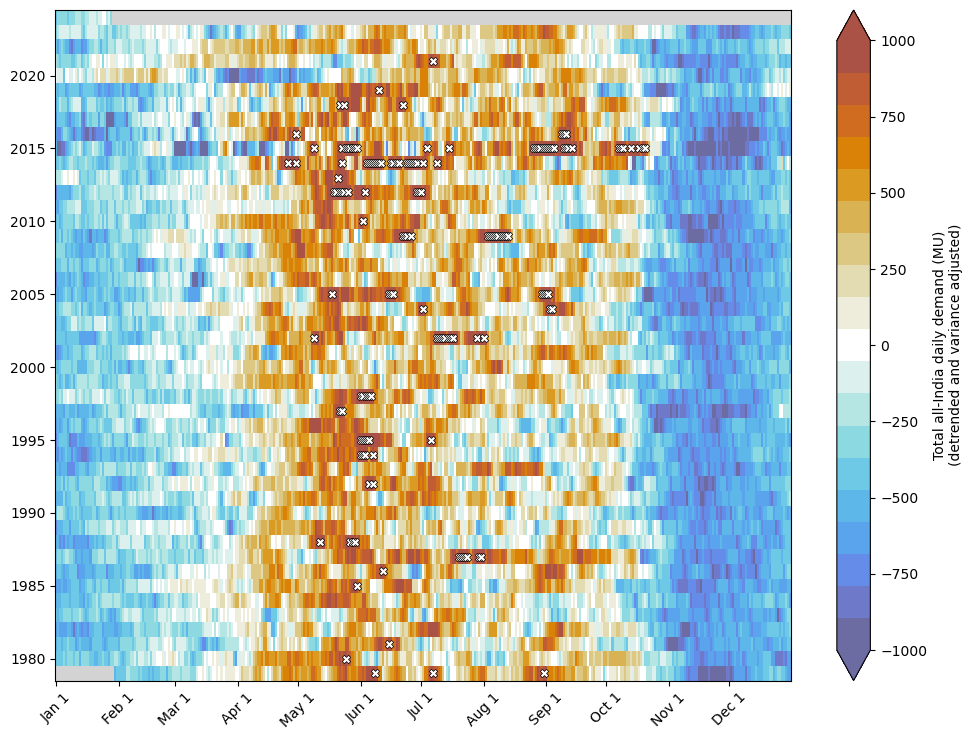

In [8]:
plt.xticks([1,32,60,91,121,152,182,213,244,274,305,335])
plt.gca().set_xticklabels(['Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'May 1', 'Jun 1',
                 'Jul 1', 'Aug 1', 'Sep 1', 'Oct 1', 'Nov 1', 'Dec 1'], 
					 rotation=45)
plt.gca().set_yticks(np.arange(1980,2025,5))

cb = plt.colorbar(cs, extend='both')
cb.set_label("Total all-India daily demand (MU)\n(detrended and variance adjusted)")


plt.tight_layout()
plt.show()